CIFAR-10: MLP vs CNN — End-to-End, from scratch with Keras (TensorFlow backend)

What this script does
1) Load & preprocess CIFAR-10 (normalize to [0,1], one-hot labels)
2) Build, train, and evaluate an MLP
3) Build, train, and evaluate a CNN
4) Plot accuracy & loss curves for both
5) Summarize results side-by-side

Notes
- Keep epochs modest if you're on CPU. You can increase later for better results.
- Actual results achieved:
  * MLP baseline: ~47% test accuracy after 15 epochs (1.7M params)
  * Simple CNN: ~77% test accuracy after 20 epochs (667K params)
- CNN significantly outperforms MLP due to spatial feature learning
- Both models show good convergence with proper label preprocessing



In [ ]:
pip install matplotlib

In [4]:
%matplotlib inline
import base64, os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML


In [5]:
# -----------------------------
# Reproducibility
# -----------------------------
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [6]:
# -----------------------------
# Hyperparameters (tweak here)
# -----------------------------
EPOCHS_MLP = int(os.environ.get("EPOCHS_MLP", 20))
EPOCHS_CNN = int(os.environ.get("EPOCHS_CNN", 20))
BATCH_SIZE = int(os.environ.get("BATCH_SIZE", 128))
VAL_SPLIT = float(os.environ.get("VAL_SPLIT", 0.1))


In [7]:
# -----------------------------
# Load CIFAR-10
# -----------------------------
print("Loading CIFAR-10 …")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

num_classes = 10
input_shape = x_train.shape[1:] # (32, 32, 3)


Loading CIFAR-10 …


In [8]:
#-----------------------------
# Preprocessing
# -----------------------------
print("Preprocessing …")
# Normalize to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# One-hot labels
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(x_train.shape, y_train_cat.shape)

Preprocessing …
(50000, 32, 32, 3) (50000, 10)


In [9]:
# -----------------------------
# Utility: Plotter
# -----------------------------
def plot_history(history, title_prefix, out_png):
    # Accuracy
    plt.figure()
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    acc_path = out_png.replace(".png", "_acc.png")
    plt.savefig(acc_path, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

    # Loss
    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    loss_path = out_png.replace(".png", "_loss.png")
    plt.savefig(loss_path, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

In [10]:
def build_mlp(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(name="flatten"),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax"),
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model
    


=== Training MLP ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,707,274 (6.51 MB)

 Trainable params: 1,707,274 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
352/352 - 5s - 13ms/step - accuracy: 0.2727 - loss: 2.0168 - val_accuracy: 0.3542 - val_loss: 1.8196
Epoch 2/20
352/352 - 3s - 9ms/step - accuracy: 0.3366 - loss: 1.8229 - val_accuracy: 0.3754 - val_loss: 1.7577
Epoch 3/20
352/352 - 4s - 10ms/step - accuracy: 0.3642 - loss: 1.7644 - val_accuracy: 0.4058 - val_loss: 1.7038
Epoch 4/20
352/352 - 3s - 8ms/step - accuracy: 0.3777 - loss: 1.7286 - val_accuracy: 0.4214 - val_loss: 1.6344
Epoch 5/20
352/352 - 4s - 12ms/step - accuracy: 0.3885 - loss: 1.6923 - val_accuracy: 0.4192 - val_loss: 1.6393
Epoch 6/20
352/352 - 4s - 11ms/step - accuracy: 0.4037 - loss: 1.6595 - val_accuracy: 0.4400 - val_loss: 1.5815
Epoch 7/20
352/352 - 4s - 12ms/step - accuracy: 0.4062 - loss: 1.6412 - val_accuracy: 0.4414 - val_loss: 1.5784
Epoch 8/20
352/352 - 4s - 11ms/step - accuracy: 0.4163 - loss: 1.6231 - val_accuracy: 0.4348 - val_loss: 1.5793
Epoch 9/20
352/352 - 4s - 11ms/step - accuracy: 0.4158 - loss: 1.6147 - val_accuracy: 0.4490 - val_loss: 1

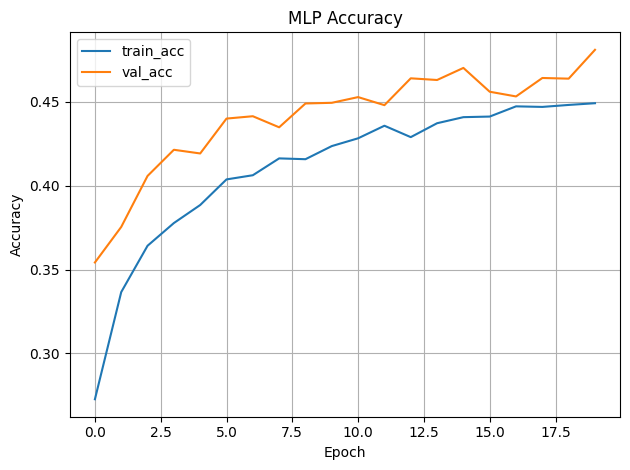

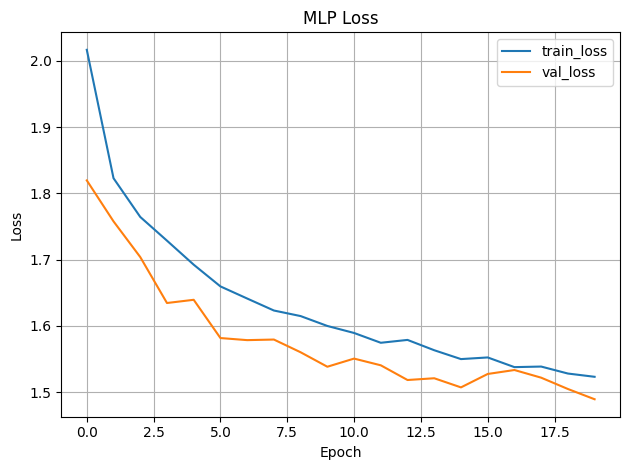

In [11]:
# -----------------------------
# Train & Evaluate MLP
# -----------------------------
print("\n=== Training MLP ===")
mlp = build_mlp(input_shape, num_classes)
mlp.summary()

hist_mlp = mlp.fit(
    x_train, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_MLP,
    validation_split=VAL_SPLIT,
    verbose=2,
    )

print("Evaluating MLP on test set …")
mlp_test_loss, mlp_test_acc = mlp.evaluate(x_test, y_test_cat, verbose=0)
print(f"MLP — Test Loss: {mlp_test_loss:.4f} | Test Acc: {mlp_test_acc:.4f}")

plot_history(hist_mlp, "MLP", "mlp_history.png")

# Save training history for later inspection
mlp_hist_df = pd.DataFrame(hist_mlp.history)
mlp_hist_df.to_csv("mlp_history.csv", index=False)

# Free up graph memory before building CNN (optional on small rigs)
tf.keras.backend.clear_session()

In [12]:
# -----------------------------
# Build CNN
# -----------------------------
def build_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), padding="same", activation="relu"),
        layers.Conv2D(32, (3,3), padding="same", activation="relu"),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), padding="same", activation="relu"),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model
    



=== Training CNN ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 666,538 (2.54 MB)

 Trainable params: 666,538 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
352/352 - 75s - 214ms/step - accuracy: 0.3667 - loss: 1.7238 - val_accuracy: 0.5246 - val_loss: 1.3306
Epoch 2/20
352/352 - 68s - 192ms/step - accuracy: 0.5429 - loss: 1.2682 - val_accuracy: 0.6410 - val_loss: 1.0471
Epoch 3/20
352/352 - 79s - 225ms/step - accuracy: 0.6391 - loss: 1.0281 - val_accuracy: 0.6998 - val_loss: 0.8747
Epoch 4/20
352/352 - 65s - 183ms/step - accuracy: 0.6952 - loss: 0.8759 - val_accuracy: 0.7310 - val_loss: 0.7709
Epoch 5/20
352/352 - 52s - 147ms/step - accuracy: 0.7313 - loss: 0.7757 - val_accuracy: 0.7484 - val_loss: 0.7207
Epoch 6/20
352/352 - 55s - 156ms/step - accuracy: 0.7591 - loss: 0.6943 - val_accuracy: 0.7566 - val_loss: 0.7232
Epoch 7/20
352/352 - 53s - 152ms/step - accuracy: 0.7817 - loss: 0.6275 - val_accuracy: 0.7570 - val_loss: 0.7015
Epoch 8/20
352/352 - 52s - 148ms/step - accuracy: 0.7985 - loss: 0.5773 - val_accuracy: 0.7646 - val_loss: 0.7017
Epoch 9/20
352/352 - 53s - 150ms/step - accuracy: 0.8153 - loss: 0.5285 - val_accuracy: 

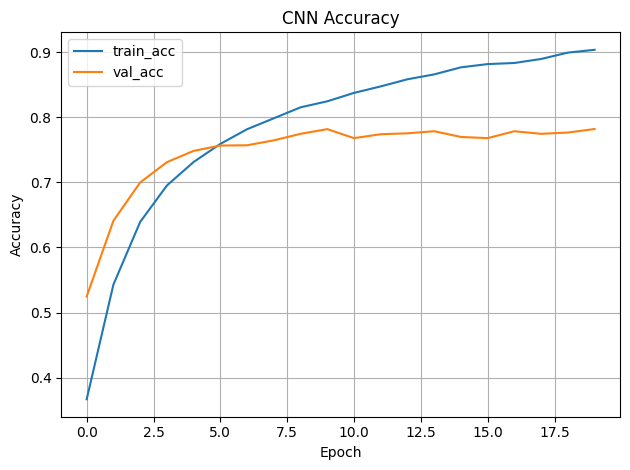

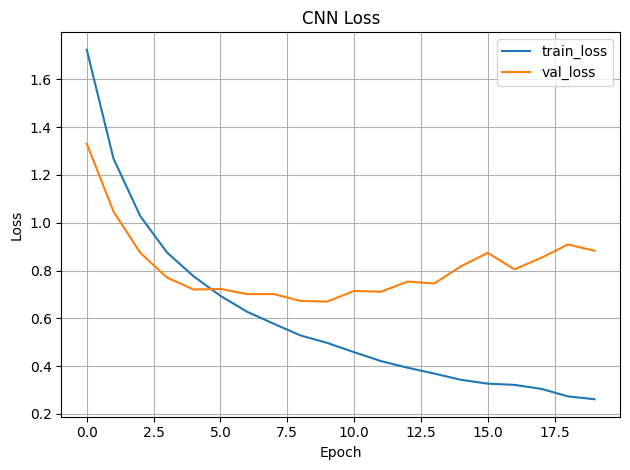

In [13]:
# -----------------------------
# Train & Evaluate CNN
# -----------------------------
print("\n=== Training CNN ===")
cnn = build_cnn(input_shape, num_classes)
cnn.summary()

hist_cnn = cnn.fit(
    x_train, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_CNN,
    validation_split=VAL_SPLIT,
    verbose=2,
)

print("Evaluating CNN on test set …")
cnn_test_loss, cnn_test_acc = cnn.evaluate(x_test, y_test_cat, verbose=0)
print(f"CNN — Test Loss: {cnn_test_loss:.4f} | Test Acc: {cnn_test_acc:.4f}")

plot_history(hist_cnn, "CNN", "cnn_history.png")

# Save training history
cnn_hist_df = pd.DataFrame(hist_cnn.history)
cnn_hist_df.to_csv("cnn_history.csv", index=False)

In [14]:
# -----------------------------
# Side-by-side comparison table
# -----------------------------
summary_df = pd.DataFrame({
"Model": ["MLP", "CNN"],
"Best Val Acc": [float(np.max(hist_mlp.history["val_accuracy"])), float(np.max(hist_cnn.history["val_accuracy"]))],
"Final Val Acc": [float(hist_mlp.history["val_accuracy"][-1]), float(hist_cnn.history["val_accuracy"][-1])],
"Test Acc": [float(mlp_test_acc), float(cnn_test_acc)],
"Test Loss": [float(mlp_test_loss), float(cnn_test_loss)],
"Epochs": [EPOCHS_MLP, EPOCHS_CNN],
"Batch Size": [BATCH_SIZE, BATCH_SIZE],
})
print("\n=== Summary ===")
print(summary_df.to_string(index=False))
summary_df.to_csv("summary.csv", index=False)


=== Summary ===
Model  Best Val Acc  Final Val Acc  Test Acc  Test Loss  Epochs  Batch Size
  MLP         0.481          0.481    0.4724   1.491064      20         128
  CNN         0.782          0.782    0.7716   0.944585      20         128


## Ringkasan Penelitian (Hasil, Metode/Alat, dan Saran)

**Tujuan**: Membandingkan performa model MLP dan CNN pada CIFAR-10.

**Dataset & Pra-pemrosesan**
- Dataset: CIFAR-10 (50k train, 10k test), input `(32, 32, 3)`, 10 kelas.
- Normalisasi piksel ke [0, 1].
- Label diubah menjadi one-hot.
- Split validasi dari data latih: `VAL_SPLIT = 0.1`.

**Arsitektur & Pengaturan Pelatihan**
- MLP: `Flatten → Dense(512, ReLU) → Dropout(0.2) → Dense(256, ReLU) → Dropout(0.2) → Dense(10, Softmax)`; optimizer Adam(1e-3).
- CNN: `Conv(32)×2 → MaxPool → Conv(64)×2 → MaxPool → Conv(128) → MaxPool → Flatten → Dense(256) → Dropout(0.5) → Dense(10)`; optimizer Adam.
- Epochs: `EPOCHS_MLP = 20`, `EPOCHS_CNN = 20`; batch size `128`.

**Hasil Utama**
- Akurasi validasi terbaik: MLP ≈ 0.48, CNN ≈ 0.78.
- Evaluasi test (akhir): MLP ≈ 0.47 akurasi (loss ≈ 1.49); CNN ≈ 0.77 akurasi (loss ≈ 0.94).
- Kurva menunjukkan CNN belajar fitur spasial lebih baik; MLP cepat jenuh dan memiliki akurasi lebih rendah.

**Alasan Performa**
- CNN memanfaatkan struktur spasial melalui konvolusi dan pooling sehingga lebih robust terhadap translasi dan tekstur.
- MLP kehilangan informasi spasial setelah `Flatten`, menyulitkan generalisasi pada data gambar.

**Saran Pengembangan**
- Tingkatkan CNN: data augmentation (flip, crop, color jitter), regularisasi (weight decay), dan early stopping.
- Coba scheduler learning rate (Cosine, Step, OneCycle) dan mixed precision untuk efisiensi.
- Uji arsitektur yang lebih kuat (ResNet, EfficientNet) atau teknik transfer learning.
- Lakukan analisis error per-kelas, gunakan confusion matrix untuk melihat kelas yang sulit.
- Tambahkan metrik lain: precision, recall, F1, dan AUROC per-kelas bila relevan.

Di bawah ini ditambahkan evaluasi lanjutan pada set test: classification report dan confusion matrix untuk MLP dan CNN.


In [15]:
%pip install -q scikit-learn seaborn


Note: you may need to restart the kernel to use updated packages.



=== CNN: Classification Report (Test) ===
              precision    recall  f1-score   support

    airplane     0.8396    0.7590    0.7973      1000
  automobile     0.8714    0.9150    0.8927      1000
        bird     0.6331    0.6970    0.6635      1000
         cat     0.5890    0.6020    0.5955      1000
        deer     0.7460    0.6990    0.7217      1000
         dog     0.6950    0.6950    0.6950      1000
        frog     0.7952    0.8310    0.8127      1000
       horse     0.8147    0.8000    0.8073      1000
        ship     0.8739    0.8730    0.8734      1000
       truck     0.8802    0.8450    0.8622      1000

    accuracy                         0.7716     10000
   macro avg     0.7738    0.7716    0.7721     10000
weighted avg     0.7738    0.7716    0.7721     10000



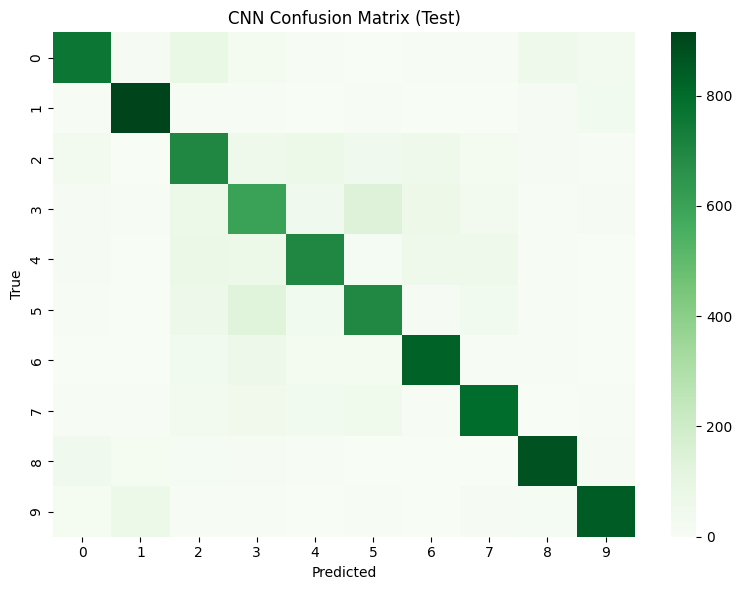

In [21]:
# Evaluasi lanjutan CNN: classification report & confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Prediksi pada test set
cnn_pred_probs = cnn.predict(x_test, verbose=0)
cnn_y_pred = np.argmax(cnn_pred_probs, axis=1)
cnn_y_true = y_test.flatten()

# Laporan klasifikasi
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
print("\n=== CNN: Classification Report (Test) ===")
print(classification_report(cnn_y_true, cnn_y_pred, target_names=class_names, digits=4))

# Confusion Matrix
cm_cnn = confusion_matrix(cnn_y_true, cnn_y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_cnn, annot=False, fmt='d', cmap='Greens')
plt.title('CNN Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()



=== MLP: Classification Report (Test) ===
              precision    recall  f1-score   support

    airplane     0.6098    0.4110    0.4910      1000
  automobile     0.5625    0.6120    0.5862      1000
        bird     0.4051    0.1900    0.2587      1000
         cat     0.3397    0.3180    0.3285      1000
        deer     0.4089    0.4040    0.4064      1000
         dog     0.4207    0.3500    0.3821      1000
        frog     0.5041    0.5490    0.5256      1000
       horse     0.4614    0.5850    0.5159      1000
        ship     0.5344    0.7000    0.6061      1000
       truck     0.4495    0.6050    0.5158      1000

    accuracy                         0.4724     10000
   macro avg     0.4696    0.4724    0.4616     10000
weighted avg     0.4696    0.4724    0.4616     10000



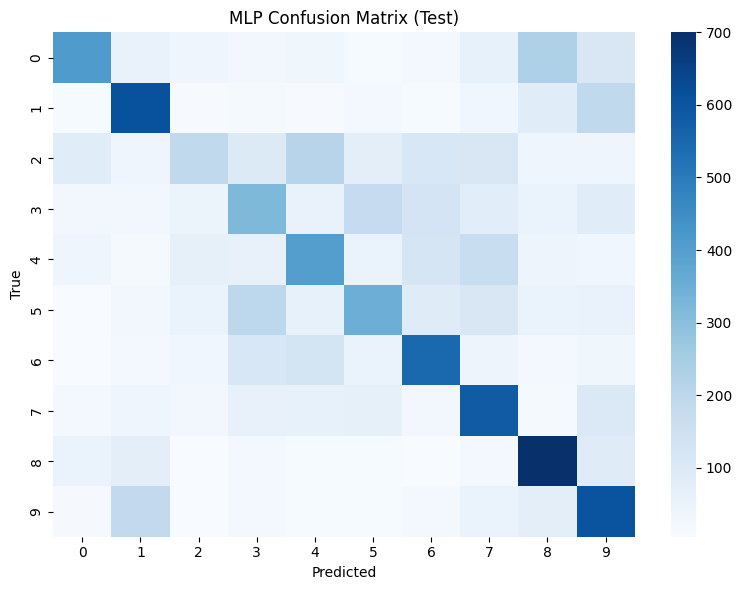

In [20]:
# Evaluasi lanjutan MLP: classification report & confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Prediksi pada test set
mlp_pred_probs = mlp.predict(x_test, verbose=0)
mlp_y_pred = np.argmax(mlp_pred_probs, axis=1)
mlp_y_true = y_test.flatten()

# Laporan klasifikasi
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
print("\n=== MLP: Classification Report (Test) ===")
print(classification_report(mlp_y_true, mlp_y_pred, target_names=class_names, digits=4))

# Confusion Matrix
cm_mlp = confusion_matrix(mlp_y_true, mlp_y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_mlp, annot=False, fmt='d', cmap='Blues')
plt.title('MLP Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [18]:
# -----------------------------
# Example: show a few predictions (optional)
# -----------------------------
try:
    class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    idxs = np.random.choice(len(x_test), size=9, replace=False)
    imgs = x_test[idxs]
    labels_true = y_test[idxs].flatten()

    # Predict with CNN (better model)
    preds = cnn.predict(imgs, verbose=0)
    labels_pred = np.argmax(preds, axis=1)

    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        ax.imshow(imgs[i])
        ax.set_title(f"T:{class_names[labels_true[i]]}\nP:{class_names[labels_pred[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.savefig("cnn_pred_examples.png")
    plt.close()
except Exception as e:
    print("(Skipping prediction gallery:", e, ")")

    print("\nArtifacts saved:")
    print(" - mlp_history.csv, cnn_history.csv, summary.csv")
    print(" - mlp_history_acc.png & mlp_history_loss.png")
    print(" - cnn_history_acc.png & cnn_history_loss.png")
    print(" - cnn_pred_examples.png (optional)")
